# XGBoost + skopt
Alex Duarte (**[@leaxp](http://www.github.com/leaxp)**) - 2017

In [3]:
# Load modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.2)
from tqdm import trange
from IPython import display
import time
import os

import xgboost as xgb
from skopt import gbrt_minimize
from skopt.plots import plot_convergence
from skopt import Optimizer
from skopt.learning import GradientBoostingQuantileRegressor
from sklearn.externals.joblib import Parallel, delayed


from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # resolution improve for macbook 

In [4]:
# Define the writelog function

def writelog(file='log.txt', name ='Python notebook output', *vars ):
    ''' Function that appends cell output in a log file. 
    Usage:
        writelog('log_filename.txt', 'title name', 'params)
    '''
    
    localtime = '[' + time.asctime( time.localtime(time.time()) ) + ']'
    try:
        open(file, 'r')
    except:
        open(file, 'w+')
    with open(file, 'r') as f:
        with open('tmp.txt', 'w') as f2:
            f2.write('*****************************')
            f2.write('\n'+ localtime + ' - ' + name + '\n')
            for i in vars:
                f2.write('\n' + str(i) + '\n')
            f2.write('\n'+ f.read())        
    os.rename('tmp.txt', file)

In [9]:
# Load dataset
home = 'data/walthamstow/'
data = pd.read_csv(home + '/dataset_encoded.csv')

In [10]:
test = pd.read_csv(home + '/dataset.csv')
test.district.unique()

array(['Waltham Forest'], dtype=object)

In [11]:
# data = data.loc[data.type==1] #  Flat
data = data.loc[data.type==4] #  Terrace
# data = data.loc[(data.type==0) | (data.type==2) | (data.type==3)]  # Others

In [12]:
len(data)

9564

In [13]:
# Set X and y
X = data.drop(['price'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=23)

In [14]:
len(X_train)

7651

## Parallelized search

In [15]:
# Initialize the model
%store -r param
reg = XGBRegressor(**param)

In [16]:
# Define objective function

def objective(params):
    max_depth, learning_rate, n_estimators, min_child_weight, gamma, subsample, colsample_bytree, reg_alpha, scale_pos_weight, reg_lambda = params
    
    reg.set_params(max_depth = max_depth, 
                   learning_rate = learning_rate,
                   n_estimators = n_estimators,
                   min_child_weight = min_child_weight,
                   gamma = gamma, 
                   subsample = subsample, 
                   colsample_bytree = colsample_bytree, 
                   reg_alpha = reg_alpha,
                   scale_pos_weight = scale_pos_weight,
                   reg_lambda = reg_lambda
                  )
    return -np.mean(cross_val_score(reg, X_train, y_train, cv=5, 
                                    scoring="neg_median_absolute_error")) # try neg_median_absolute_error

In [17]:
# Load optimizer
# import pickle
# with open('data/csv/london/opt_london_terrace.pkl', 'rb') as f:
#     opt = pickle.load(f)

In [18]:
# Declare the optimizer
%store -r space

opt = Optimizer(dimensions=space, base_estimator="GBRT",
                acq_optimizer="sampling", acq_func='gp_hedge', n_initial_points= 15)
# GradientBoostingQuantileRegressor()

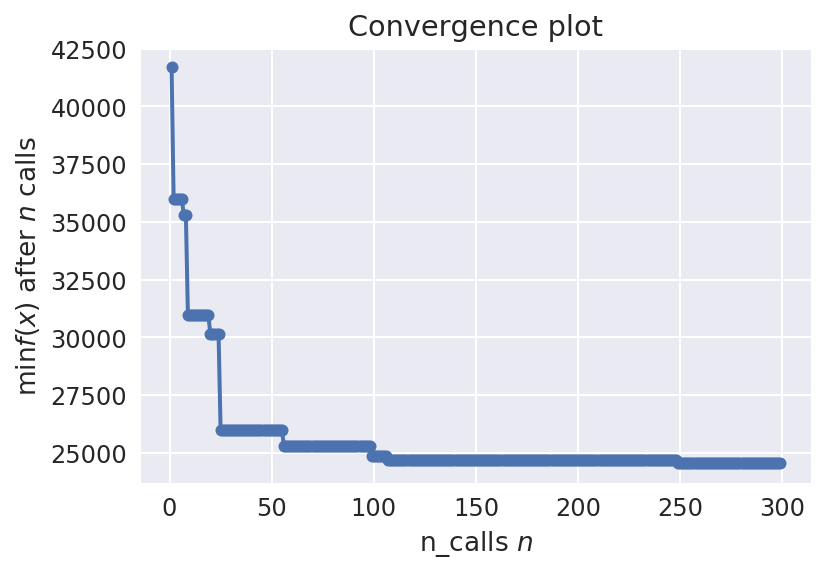

min:24572.80: 100%|███████████████████████████████████| 300/300 [1:59:15<00:00, 20.90s/it]


Best score: 24572.802
{'reg_alpha': 6.1020652053682705, 'colsample_bytree': 0.9395125154933911, 'scale_pos_weight': 1.5750030059082857e-05, 'learning_rate': 0.0031555458412805991, 'min_child_weight': 1.0094490733951442, 'n_estimators': 5549, 'subsample': 0.30321960372451229, 'reg_lambda': 0.019874124670470162, 'max_depth': 7, 'gamma': 0.76981390696804963}
CPU times: user 1d 22h 27min 59s, sys: 4min 12s, total: 1d 22h 32min 12s
Wall time: 1h 59min 15s


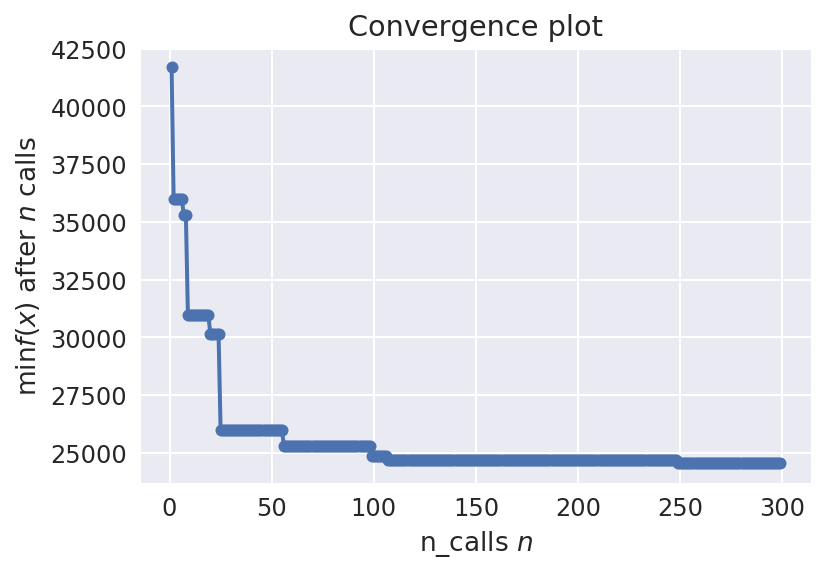

In [19]:
%%time
sns.set(font_scale = 1.2)
vals = []

%store -r param sp_label

# Minimize the objective function 
try:
    t = trange(300, ncols=90)
    for i in t:
        x = opt.ask()    
        y = objective(x)   
        opt.tell(x, y)
        #plot convergence
        it = range(1, i + 1)
        vals = np.append(vals, y)
        t.set_description("min:{:.2f}".format(np.min(vals)))
        mins = [np.min(vals[:i]) for i in it]
        plt.gca().cla()
        plt.title("Convergence plot")
        plt.xlabel("n_calls $n$")
        plt.ylabel(r"$\min f(x)$ after $n$ calls")
        plt.plot(it, mins, marker=".", markersize=12, lw=2)
        display.clear_output(wait=True)
        display.display(plt.gcf())     
        
except:
    print('Interruped on {} iteration.'.format(len(opt.yi)))
    
    
print('Best score: {:.3f}'.format(min(opt.yi)))
best_param = opt.Xi[np.argmin(opt.yi)]
print(dict(zip(sp_label, best_param)))

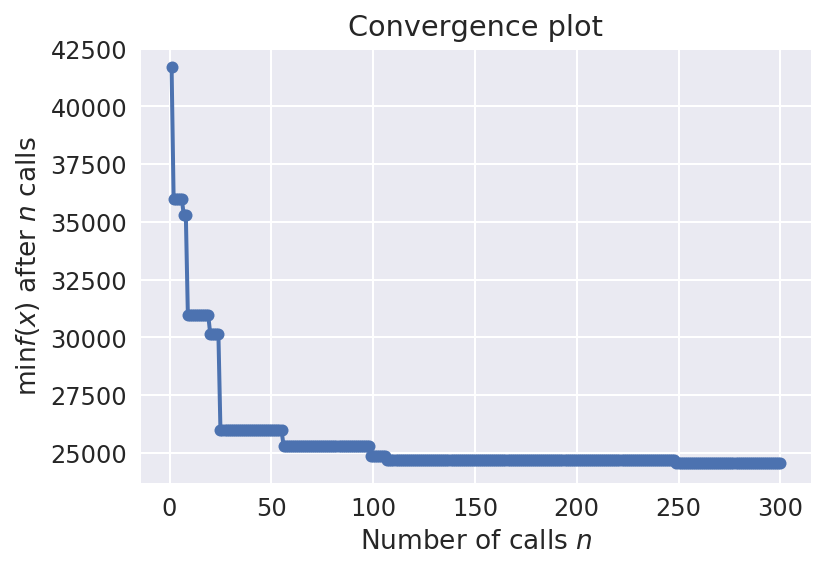

In [20]:
#Plot convergence using optimizer
sns.set(font_scale = 1.2)

offset = 0
it = range(1 + offset, len(opt.yi) + 1)
mins = [np.min(opt.yi[offset:i]) for i in it]  
plt.title("Convergence plot")
plt.xlabel("Number of calls $n$")
plt.ylabel(r"$\min f(x)$ after $n$ calls")
plt.plot(it, mins, marker=".", markersize=12, lw=2);

In [21]:
print('Best score: {:.3f}'.format(min(opt.yi)))
best_param = opt.Xi[np.argmin(opt.yi)]
print(dict(zip(sp_label, best_param)))

Best score: 24572.802
{'reg_alpha': 6.1020652053682705, 'colsample_bytree': 0.9395125154933911, 'scale_pos_weight': 1.5750030059082857e-05, 'learning_rate': 0.0031555458412805991, 'min_child_weight': 1.0094490733951442, 'n_estimators': 5549, 'subsample': 0.30321960372451229, 'reg_lambda': 0.019874124670470162, 'max_depth': 7, 'gamma': 0.76981390696804963}


In [18]:
#log file register

%store -r log_file sp_label

best_param = opt.Xi[np.argmin(opt.yi)]
writelog(log_file, 'Parallel random search skopt - {}'.format(sp_label),
         'Total training set (only Walthamstow Flat 2008-2017) {} rows'.format(len(X_train)),
         'Added postcode data',
         'Number os Calls: {}'.format(len(opt.yi)),
         'Best score: {:.3f}'.format(min(opt.yi)),
         'Best Parameters:\n{}'.format(dict(zip(sp_label, best_param)))
        )

In [103]:
# Save optimizer

# import pickle

# with open('model/walthamstow/opt_walthamstow_others.pkl', 'wb') as f:
#     pickle.dump(opt, f)

# with open('opt_08.pkl', 'rb') as f:
#     opt = pickle.load(f)

In [27]:
# from skopt.plots import plot_evaluations

# _ = plot_evaluations(opt, bins=10)

In [19]:
# Load dataset
home = 'data/greenwich/'
data = pd.read_csv(home + '/dataset_encoded.csv')

In [20]:
test = pd.read_csv(home + '/dataset.csv')
test.district.unique()

array(['Greenwich'], dtype=object)

In [21]:
# data = data.loc[data.type==1] #  Flat
data = data.loc[data.type==4] #  Terrace
# data = data.loc[(data.type==0) | (data.type==2) | (data.type==3)]  # Others

In [22]:
len(data)

7341

In [23]:
# Set X and y
X = data.drop(['price'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=23)

In [24]:
len(X_train)

5872

## Parallelized search

In [25]:
# Initialize the model
%store -r param
reg = XGBRegressor(**param)

In [26]:
# Define objective function

def objective(params):
    max_depth, learning_rate, n_estimators, min_child_weight, gamma, subsample, colsample_bytree, reg_alpha, scale_pos_weight, reg_lambda = params
    
    reg.set_params(max_depth = max_depth, 
                   learning_rate = learning_rate,
                   n_estimators = n_estimators,
                   min_child_weight = min_child_weight,
                   gamma = gamma, 
                   subsample = subsample, 
                   colsample_bytree = colsample_bytree, 
                   reg_alpha = reg_alpha,
                   scale_pos_weight = scale_pos_weight,
                   reg_lambda = reg_lambda
                  )
    return -np.mean(cross_val_score(reg, X_train, y_train, cv=5, 
                                    scoring="neg_median_absolute_error")) # try neg_median_absolute_error

In [27]:
# Declare the optimizer
%store -r space

opt = Optimizer(dimensions=space, base_estimator="GBRT",
                acq_optimizer="sampling", acq_func='gp_hedge', n_initial_points= 15)
# GradientBoostingQuantileRegressor()

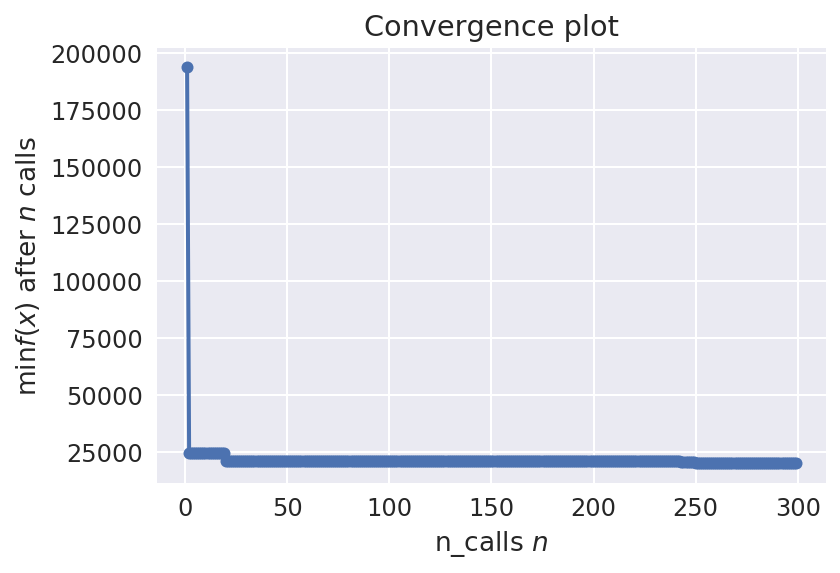

min:20065.27: 100%|███████████████████████████████████| 300/300 [1:12:27<00:00, 10.93s/it]


Best score: 20065.266
{'reg_alpha': 9.2636886947750039, 'colsample_bytree': 0.46954733170709234, 'scale_pos_weight': 0.0014362272458160632, 'learning_rate': 0.0051014379422867299, 'min_child_weight': 1.4997184477552727, 'n_estimators': 2476, 'subsample': 0.038487603780280398, 'reg_lambda': 0.00091217811166986425, 'max_depth': 28, 'gamma': 5.7440407200933175}
CPU times: user 1d 3h 46min 11s, sys: 3min 1s, total: 1d 3h 49min 12s
Wall time: 1h 12min 27s


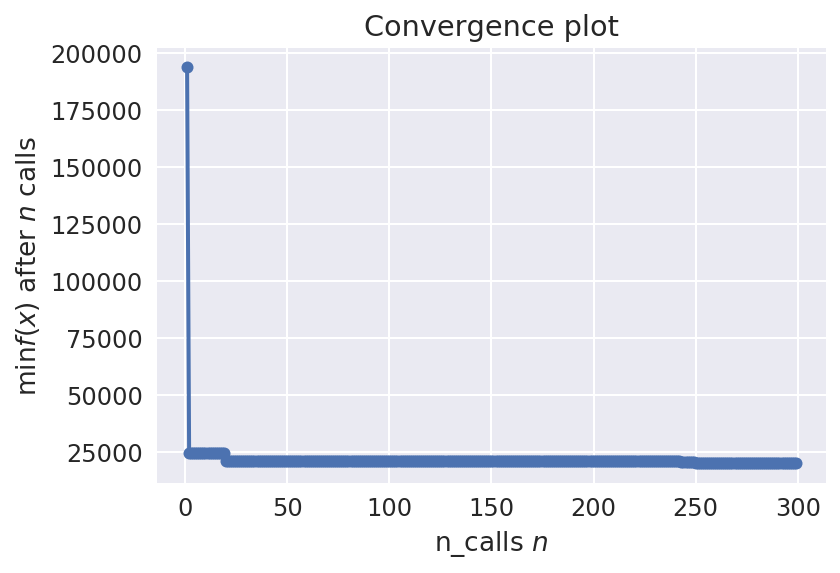

In [28]:
%%time
sns.set(font_scale = 1.2)
vals = []

%store -r param sp_label

# Minimize the objective function 
try:
    t = trange(300, ncols=90)
    for i in t:
        x = opt.ask()    
        y = objective(x)   
        opt.tell(x, y)
        #plot convergence
        it = range(1, i + 1)
        vals = np.append(vals, y)
        t.set_description("min:{:.2f}".format(np.min(vals)))
        mins = [np.min(vals[:i]) for i in it]
        plt.gca().cla()
        plt.title("Convergence plot")
        plt.xlabel("n_calls $n$")
        plt.ylabel(r"$\min f(x)$ after $n$ calls")
        plt.plot(it, mins, marker=".", markersize=12, lw=2)
        display.clear_output(wait=True)
        display.display(plt.gcf())     
        
except:
    print('Interruped on {} iteration.'.format(len(opt.yi)))
    
    
print('Best score: {:.3f}'.format(min(opt.yi)))
best_param = opt.Xi[np.argmin(opt.yi)]
print(dict(zip(sp_label, best_param)))

In [29]:
#log file register

%store -r log_file sp_label

best_param = opt.Xi[np.argmin(opt.yi)]
writelog(log_file, 'Parallel random search skopt - {}'.format(sp_label),
         'Total training set (only Walthamstow Terrace 2008-2017) {} rows'.format(len(X_train)),
         'Added postcode data',
         'Number os Calls: {}'.format(len(opt.yi)),
         'Best score: {:.3f}'.format(min(opt.yi)),
         'Best Parameters:\n{}'.format(dict(zip(sp_label, best_param)))
        )

In [30]:
# Load dataset
home = 'data/greenwich/'
data = pd.read_csv(home + '/dataset_encoded.csv')

In [31]:
test = pd.read_csv(home + '/dataset.csv')
test.district.unique()

array(['Greenwich'], dtype=object)

In [32]:
# data = data.loc[data.type==1] #  Flat
# data = data.loc[data.type==4] #  Terrace
data = data.loc[(data.type==0) | (data.type==2) | (data.type==3)]  # Others

In [33]:
len(data)

3163

In [34]:
# Set X and y
X = data.drop(['price'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=23)

In [35]:
len(X_train)

2530

## Parallelized search

In [36]:
# Initialize the model
%store -r param
reg = XGBRegressor(**param)

In [37]:
# Define objective function

def objective(params):
    max_depth, learning_rate, n_estimators, min_child_weight, gamma, subsample, colsample_bytree, reg_alpha, scale_pos_weight, reg_lambda = params
    
    reg.set_params(max_depth = max_depth, 
                   learning_rate = learning_rate,
                   n_estimators = n_estimators,
                   min_child_weight = min_child_weight,
                   gamma = gamma, 
                   subsample = subsample, 
                   colsample_bytree = colsample_bytree, 
                   reg_alpha = reg_alpha,
                   scale_pos_weight = scale_pos_weight,
                   reg_lambda = reg_lambda
                  )
    return -np.mean(cross_val_score(reg, X_train, y_train, cv=5, 
                                    scoring="neg_median_absolute_error")) # try neg_median_absolute_error

In [38]:
# Declare the optimizer
%store -r space

opt = Optimizer(dimensions=space, base_estimator="GBRT",
                acq_optimizer="sampling", acq_func='gp_hedge', n_initial_points= 15)
# GradientBoostingQuantileRegressor()

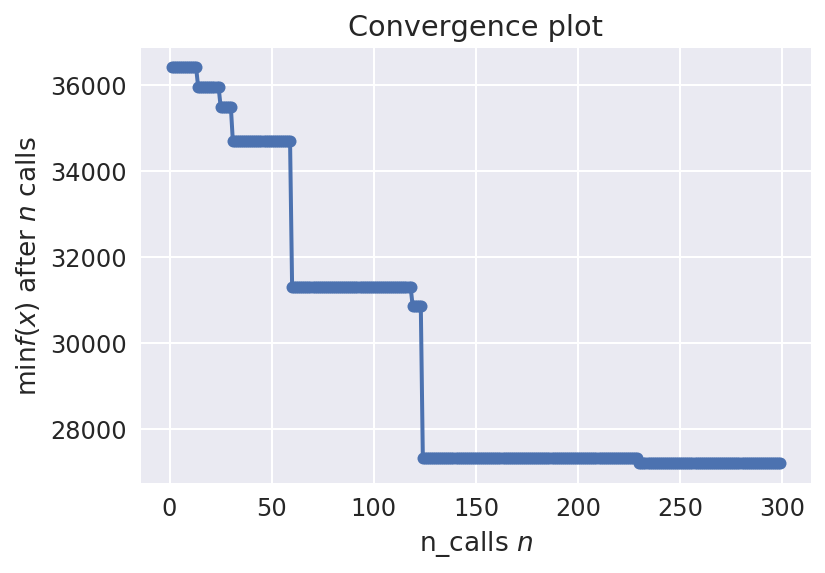

min:27219.55: 100%|█████████████████████████████████████| 300/300 [42:25<00:00,  5.93s/it]


Best score: 27219.547
{'reg_alpha': 9.9215179729261855, 'colsample_bytree': 0.82128079364579709, 'scale_pos_weight': 1.6196692161377837, 'learning_rate': 0.035483887366855489, 'min_child_weight': 1.1159978970977618, 'n_estimators': 2236, 'subsample': 0.61418693804576641, 'reg_lambda': 1.5546827753065409, 'max_depth': 17, 'gamma': 8.9402850648176404}
CPU times: user 15h 51min 17s, sys: 2min 49s, total: 15h 54min 6s
Wall time: 42min 25s


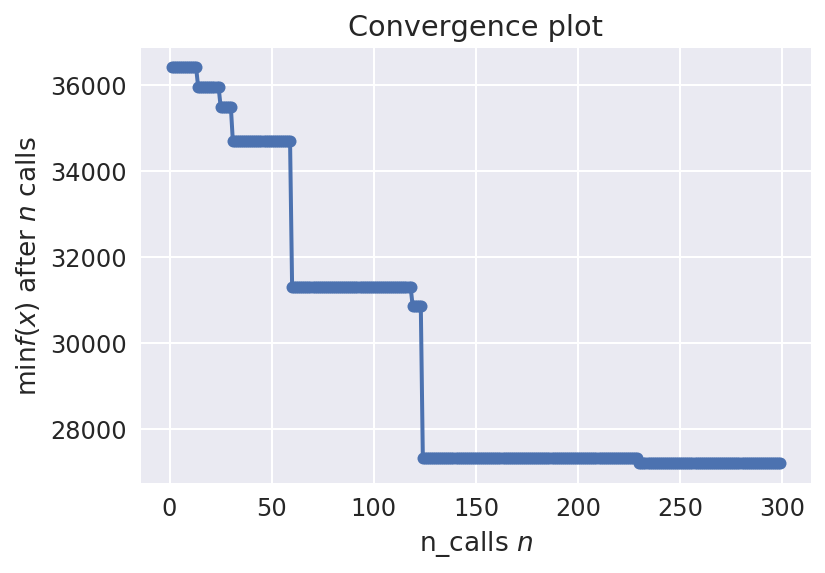

In [39]:
%%time
sns.set(font_scale = 1.2)
vals = []

%store -r param sp_label

# Minimize the objective function 
try:
    t = trange(300, ncols=90)
    for i in t:
        x = opt.ask()    
        y = objective(x)   
        opt.tell(x, y)
        #plot convergence
        it = range(1, i + 1)
        vals = np.append(vals, y)
        t.set_description("min:{:.2f}".format(np.min(vals)))
        mins = [np.min(vals[:i]) for i in it]
        plt.gca().cla()
        plt.title("Convergence plot")
        plt.xlabel("n_calls $n$")
        plt.ylabel(r"$\min f(x)$ after $n$ calls")
        plt.plot(it, mins, marker=".", markersize=12, lw=2)
        display.clear_output(wait=True)
        display.display(plt.gcf())     
        
except:
    print('Interruped on {} iteration.'.format(len(opt.yi)))
    
    
print('Best score: {:.3f}'.format(min(opt.yi)))
best_param = opt.Xi[np.argmin(opt.yi)]
print(dict(zip(sp_label, best_param)))

In [40]:
#log file register

%store -r log_file sp_label

best_param = opt.Xi[np.argmin(opt.yi)]
writelog(log_file, 'Parallel random search skopt - {}'.format(sp_label),
         'Total training set (only Walthamstow Others 2008-2017) {} rows'.format(len(X_train)),
         'Added postcode data',
         'Number os Calls: {}'.format(len(opt.yi)),
         'Best score: {:.3f}'.format(min(opt.yi)),
         'Best Parameters:\n{}'.format(dict(zip(sp_label, best_param)))
        )